In [1]:
import json
from enum import Enum
from hashlib import md5
from logging import basicConfig, getLogger
from pathlib import Path
import math
import boto3
import cv2
from scipy.ndimage.filters import gaussian_filter
import numpy as np
import rerun as rr
import structlog
from collections import defaultdict
import torch
import torchvision
import ultralytics
from kornia.geometry import unproject_points
from structlog import wrap_logger
from torch.functional import F

from courtvision.data import (
    Annotation,
    ClipSegmentResult,
    CourtAnnotatedSample,
    CourtVisionArtifacts,
    KeypointValue,
    PadelDataset,
    RectValue,
    StreamType,
    VideoRectValue,
    dict_to_points,
    download_data_item,
    frames_from_clip_segments,
    get_normalized_calibration_image_points_and_clip_ids,
)
from courtvision.geometry import (
    CameraInfo,
    PadelCourt,
    calibrate_and_evaluate,
    calibrate_camera,
    convert_obj_points_to_planar,
    corners_world_3d,
    denormalize_as_named_points,
    find_optimal_calibration_and_pose,
    get_planar_point_correspondences,
    get_planar_points_padel_court,
    project_points_to_base_plane,
    camera_space_to_world_space,
    compute_ray_intersecting_plane,
)
from courtvision.models import BallDetector, PlayerDetector
from courtvision.swiss import get_latest_file, mark_as_deprecated
from courtvision.trackers import ParticleFilter
from courtvision.vis import (
    colours_per_player_idx,
    log_ball_detections,
    log_court_layout,
    log_player_detections,
)

/var/folders/nv/c7kqzw0j08q0bg0fjbmbbr4w0000gn/T/ipykernel_24894/3438442353.py:9: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


In [2]:
ANNOTATION_PATH = Path("../datasets/clip_segmentations")
ANNOTATION_DATA_PATH = Path("../datasets/clip_segmentations/data")
ANNOTATION_DATA_PATH.mkdir(exist_ok=True, parents=True)

court_mesh_path = Path("../blender/basic_image.glb")

annotations_file = get_latest_file(ANNOTATION_PATH, "json")
with open(annotations_file, "r") as f:
    dataset = PadelDataset(samples=json.load(f))

artifacts = CourtVisionArtifacts(
    local_cache_path=ANNOTATION_DATA_PATH / "cache",
    dataset=dataset,
    ball_detector=BallDetector(
        model_file_or_dir=Path(
            "../models/ball_detector/fasterrcnn_resnet50_fpn_project-1-at-2023-05-23-14-38-c467b6ad-67.pt"
        ),
        cache_dir=ANNOTATION_DATA_PATH / "cache",
    ),
    ball_tracker=ParticleFilter(
        num_particles=10_000,
        court_size=torch.tensor(
            [PadelCourt.width, PadelCourt.length, PadelCourt.backwall_fence_height]
        ),
    ),
    player_detector=PlayerDetector(
        model_dir=Path("../models/player_detection"),
        cache_dir=ANNOTATION_DATA_PATH / "cache",
    ),
    camera_info_path=ANNOTATION_DATA_PATH / "cache" / "camera_info.npz",
    court_layout=PadelCourt(),
)

# Calibrate camera from annotations in the dataset
artifacts = calibrate_camera(artifacts)

2023-06-29 10:09:54 [info     ] Camera already calibrated - using supplied camera_info camera_info=CameraInfo(valid_for_clip_ids={PosixPath('/Users/benjamindecharmoy/projects/courtvision/datasets/clip_segmentations/data/cache/0000/output048.mp4'), PosixPath('s3:/courtvision-source-data-ksaldjfbnv/source/0000/output047.mp4'), PosixPath('s3:/courtvision-source-data-ksaldjfbnv/source/0000/output052.mp4'), PosixPath('/Users/benjamindecharmoy/projects/courtvision/datasets/clip_segmentations/data/cache/0000/output041.mp4'), PosixPath('s3:/courtvision-source-data-ksaldjfbnv/source/0000/output043.mp4'), PosixPath('/Users/benjamindecharmoy/projects/courtvision/datasets/clip_segmentations/data/cache/0000/output043.mp4'), PosixPath('/Users/benjamindecharmoy/projects/courtvision/datasets/clip_segmentations/data/cache/0000/output047.mp4'), PosixPath('/Users/benjamindecharmoy/projects/courtvision/datasets/clip_segmentations/data/cache/0000/output052.mp4'), PosixPath('s3:/courtvision-source-data-ksal

In [3]:
artifacts.dataset.samples

[CourtAnnotatedSample(idx=487, data=AnnotationDataPath(video_url=PosixPath('s3:/courtvision-source-data-ksaldjfbnv/source/0000/output041.mp4'), video_local_path=None, image_local_path=None, image=None), annotations=[Annotation(unique_id='38ee6799-9780-4b16-bbab-90cb8bf040ac', result=[ClipSegmentResult(original_length=66.966667, clip_id='ir58N', kind='labels', value=LabelValue(start=48.24564186313338, end=57.17713093884683, labels=['rally_winner_fg'])), ClipSegmentResult(original_length=66.966667, clip_id='2mRmO', kind='labels', value=LabelValue(start=47.93362477751893, end=49.10368884857309, labels=['serve'])), ClipSegmentResult(original_length=None, clip_id='iFnnGKGnud', kind='videorectangle', value=VideoRectValue(framesCount=1608, duration=66.966667, sequence=[VideoRectSequence(frame=1, enabled=True, rotation=0.0, x=12.50000000000001, y=81.16666666666667, width=0.7500000000000004, height=0.9999999999999959, time=0.041666666666666664)], labels=['a_front_left'])), ClipSegmentResult(ori

In [4]:
cache_dir = Path("../datasets/clip_segmentations/data/cache")
heatmap = torch.zeros((int(PadelCourt.width), int(PadelCourt.length)))
heatmaps = defaultdict(lambda: heatmap.clone())
velocity_heatmaps = defaultdict(lambda: heatmap.clone())
player_positions = defaultdict(list)
player_detection_times = defaultdict(list)
current_uid = None
prev_frame_pts = 0
for i, (frame, uid, match) in enumerate(
    frames_from_clip_segments(
        artifacts.dataset,
        local_path=artifacts.local_cache_path,
        stream_type=StreamType.VIDEO,
    )
):
    if uid != current_uid:
        if current_uid is not None:
            pass
        current_uid = uid
    cached_detection = (
        cache_dir / PlayerDetector.PIPELINE_NAME / uid / f"detections_at_{i}.pt"
    )
    detections = torch.load(cached_detection)

    dt = frame["pts"] - prev_frame_pts
    prev_frame_pts = frame["pts"]
    for detection in detections:
        for det in detection.boxes.data:
            # TODO: Fix this hack. Use?
            # x1, y1, x2, y2, idx, *_ = det
            x1, y1, x2, y2, idx, *_ = det

            # rr.log_rect(
            #     f"world/camera/image/player_{int(idx)}",
            #     (x1, y1, (x2 - x1), (y2 - y1)),
            #     color=colours_per_player_idx[int(idx)],
            # )
            # Compute the 3D point of the player's feet
            # Use 2 depth values to unproject the point from the image plane to the camera plane
            depths = torch.tensor(
                [[1.0 * PadelCourt.court_scale, 20.0 * PadelCourt.court_scale]]
            ).T  # Depth values in [mm * PadelCourt.court_scale]
            mid_feets = torch.tensor([((x1 + x2) / 2, (y2 + y2) / 2)]).repeat(
                depths.shape[0], 1
            )
            mid_feets_base_camera_space = unproject_points(
                point_2d=mid_feets,
                camera_matrix=artifacts.camera_info.camera_matrix,
                depth=depths,
            ).squeeze(0)
            # Using the Translation and Rotation Vector of the camera, transform the point from camera space to world space
            mid_feet_base_world_space = camera_space_to_world_space(
                mid_feets_base_camera_space.squeeze(0).numpy().T,
                artifacts.camera_info.translation_vector,
                artifacts.camera_info.rotation_vector,
            )
            # Compute the intersection of the ray formed by the camera position and the 3D point with the plane
            intersection = compute_ray_intersecting_plane(
                point_a_on_ray=mid_feet_base_world_space[0].reshape(3, 1),
                point_b_on_ray=mid_feet_base_world_space[1].reshape(3, 1),
            )
            player_maker_radius = 0.1
            # rr.log_point(
            #     f"world/player_{int(idx)}",
            #     intersection,
            #     radius=player_maker_radius,
            #     color=colours_per_player_idx[int(idx)],
            # )
            pos_x, pos_y = int(intersection[0]), int(intersection[1])
            player_positions[f"{uid}_{idx}"].append((pos_x, pos_y))
            player_detection_times[f"{uid}_{idx}"].append(frame["pts"])
            if (
                pos_x < 0
                or pos_x >= PadelCourt.width
                or pos_y < 0
                or pos_y >= PadelCourt.length
            ):
                continue
            # Index per rally
            # index = f"{uid}"
            # Index per game
            index = f"{match}"
            break
            # position heatmap
            heatmaps[index][pos_x, pos_y] += 1

            if (
                len(player_positions[f"{uid}_{idx}"]) >= 2
                and len(player_detection_times[f"{uid}_{idx}"]) >= 2
            ):
                prev_pos_x, prev_pos_y = player_positions[f"{uid}_{idx}"][-2]
                # prev_frame_pts = player_detection_times[f"{uid}_{idx}"][-2]
                velocity = math.sqrt(
                    ((pos_x - prev_pos_x) / dt) ** 2 + ((pos_y - prev_pos_y) / dt) ** 2
                )
                # velocity heatmap
                velocity_heatmaps[index][pos_x, pos_y] = velocity
            # rr.log_image(
            #     f"player_{int(idx)}/heatmap",
            #     gaussian_filter(heatmaps[f"{uid}_{idx}"],5.0),
            # )

In [5]:
index

'0000'

In [66]:
frame["pts"], prev_frame_pts

(48.766666666666666, 48.766666666666666)

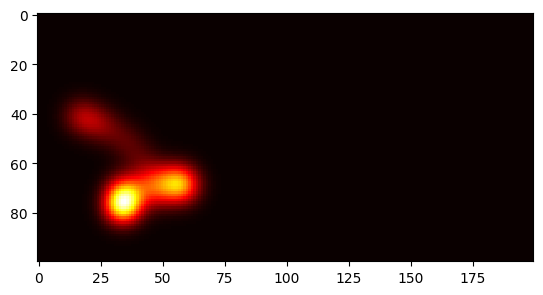

In [54]:
import matplotlib.pyplot as plt
import numpy as np


rr.log

plt.imshow(
    gaussian_filter(heatmaps["46b86895106499172f9682de0949fd61_1.0"], sigma=5.0),
    cmap="hot",
    interpolation="nearest",
)
plt.show()

In [85]:
list(heatmaps.keys()), list(velocity_heatmaps.keys())

(['46b86895106499172f9682de0949fd61',
  '356bf6e7898cf56bc194eed385bc91ee',
  'e4f4a04554d27ab77ce8dc2fa425635b',
  'edd0d3be436154571788ad2bb16446a2',
  '94055cdbe009000a0767bd9c30393559',
  '6a17af1a27ae6a189808e1633c07e2dc',
  'e315f1fa6a0fd4b7c929fbb775bdd187',
  '8d48286a4059f5231ae7b322c616ae37',
  'd80820d6fae454456baac345523575e5',
  '0f1b4bf004760ceeb40c0bb6978de81a',
  '62e526142876d34a42bfea4db57c3c09',
  '05741a43c3c75df46f5ae78a08e5740d',
  'b5ea5d0a05d9605d77907278be3b3035',
  '2cb4dec18e08ed66e05b5f3e71aa93f3',
  '61d3922c9185895fcf1279cf31b8a2c9',
  '8e0bfd6d868c26d66b6d244b34e4ae5d',
  'c01aaaf9718a167c62eee58738a53fbf'],
 ['46b86895106499172f9682de0949fd61',
  '356bf6e7898cf56bc194eed385bc91ee',
  'e4f4a04554d27ab77ce8dc2fa425635b',
  'edd0d3be436154571788ad2bb16446a2',
  '94055cdbe009000a0767bd9c30393559',
  '6a17af1a27ae6a189808e1633c07e2dc',
  'e315f1fa6a0fd4b7c929fbb775bdd187',
  '8d48286a4059f5231ae7b322c616ae37',
  'd80820d6fae454456baac345523575e5',
  '0f1b4bf0

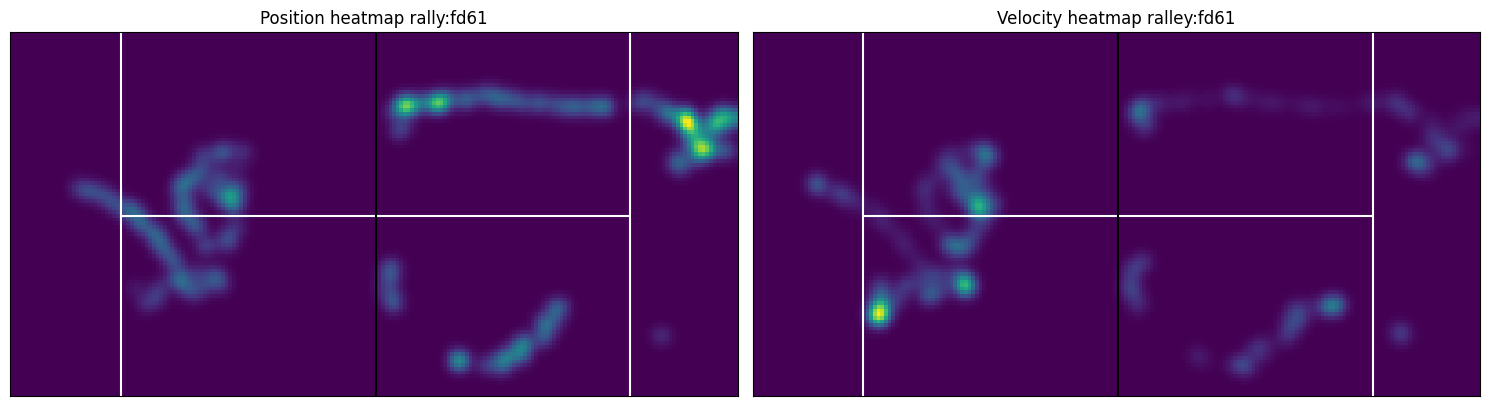

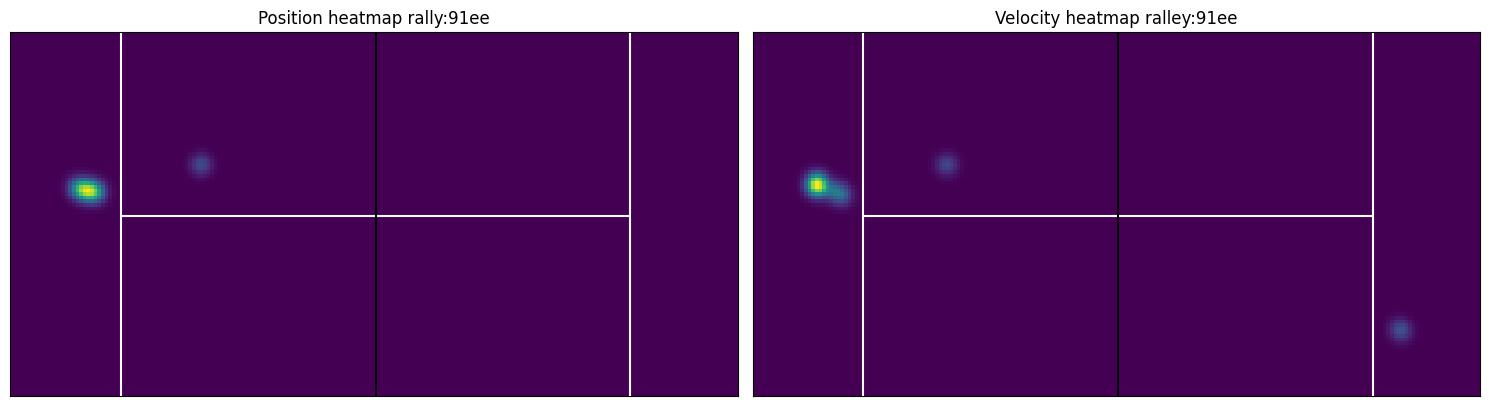

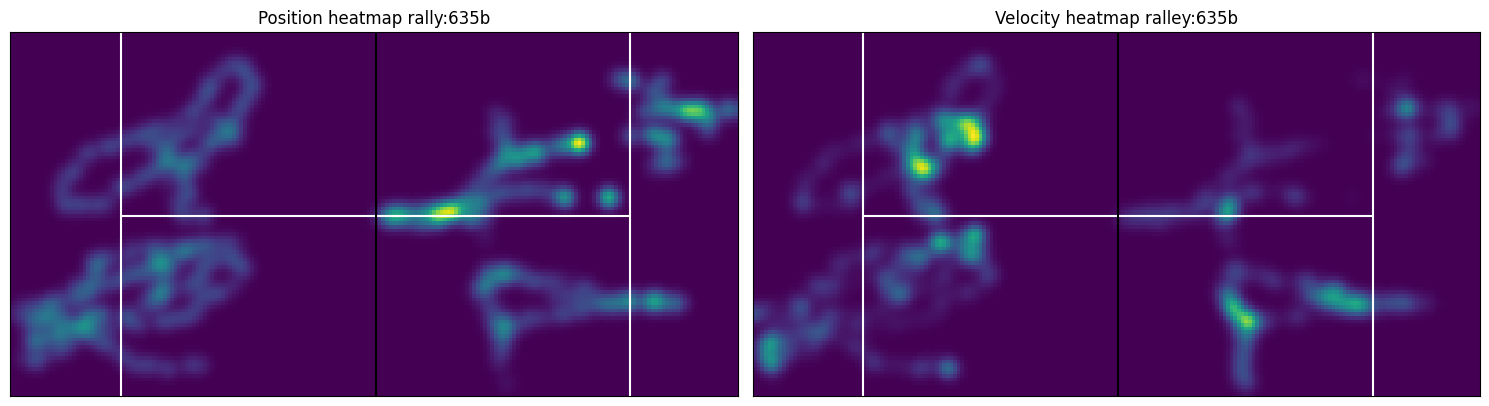

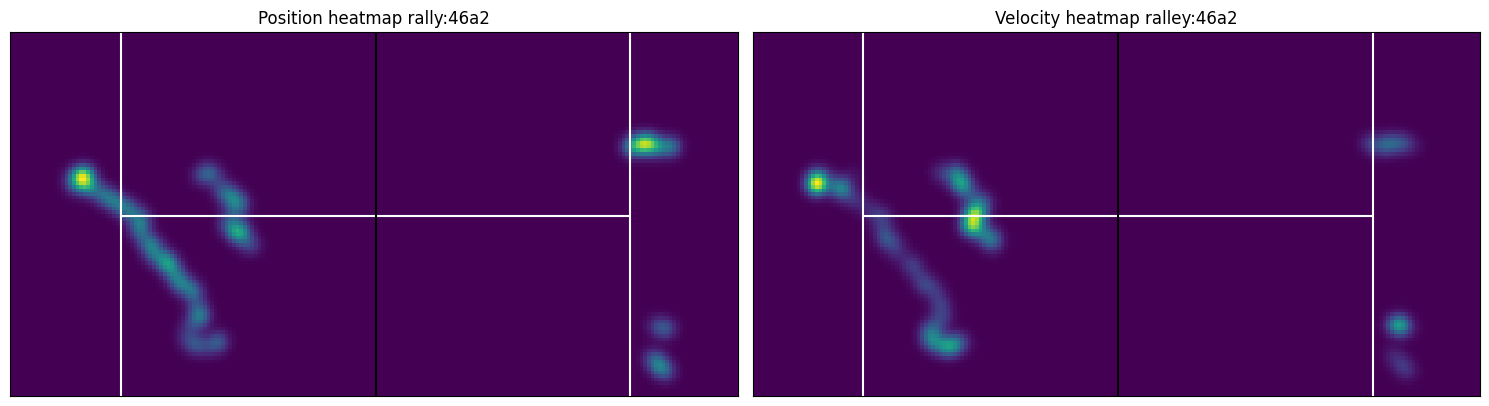

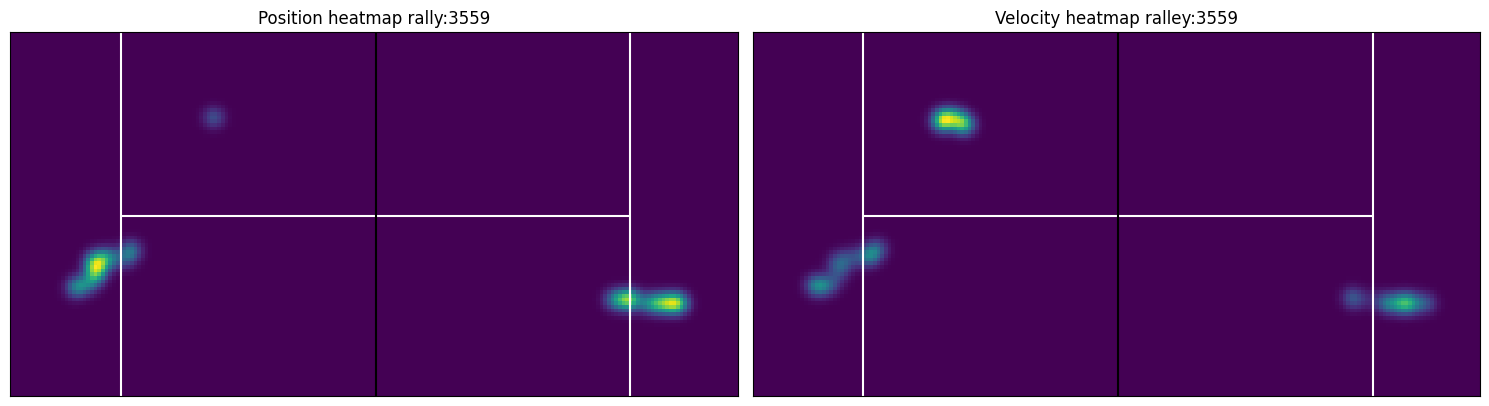

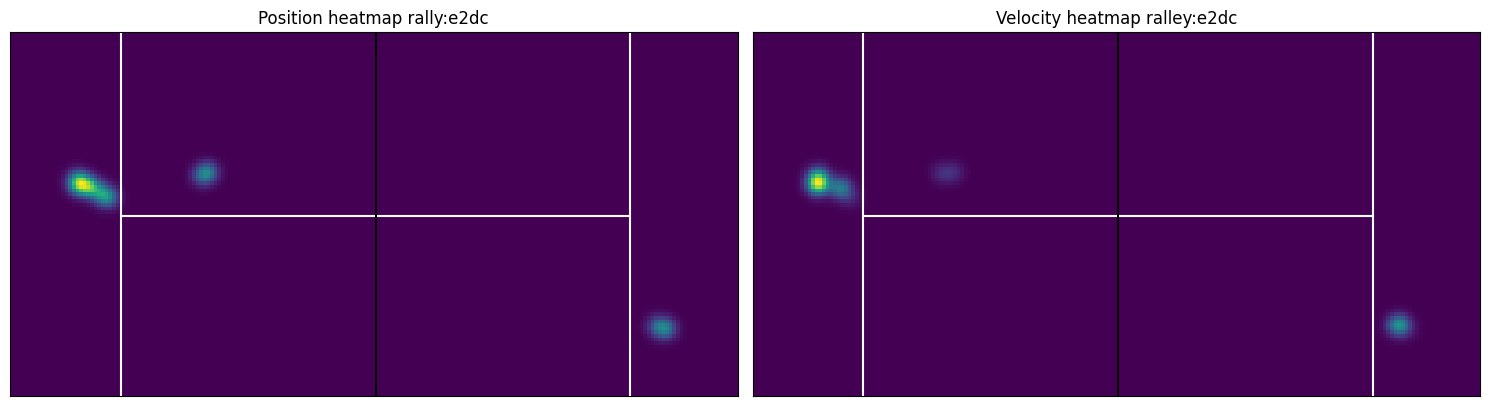

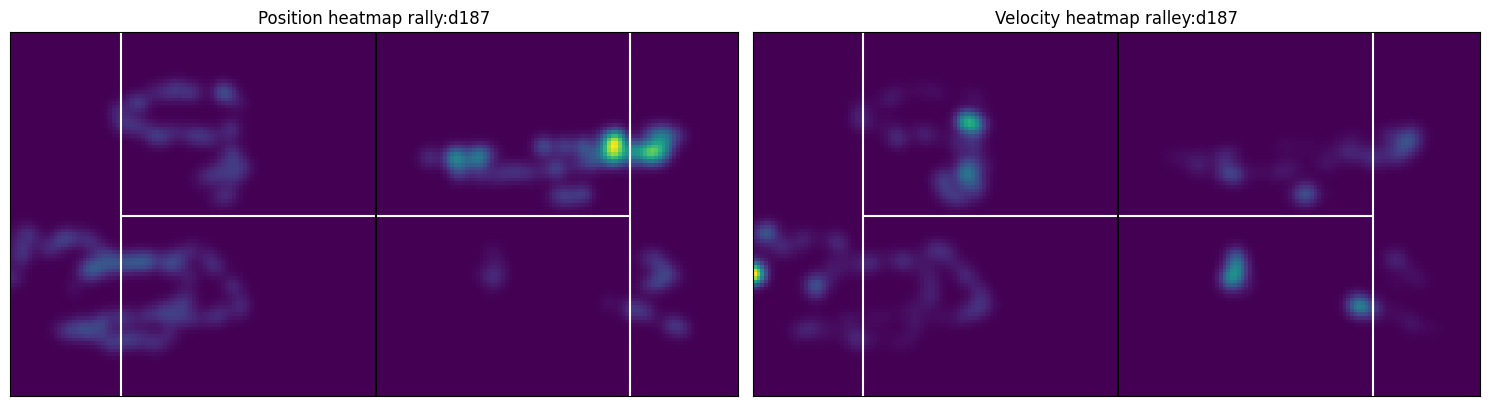

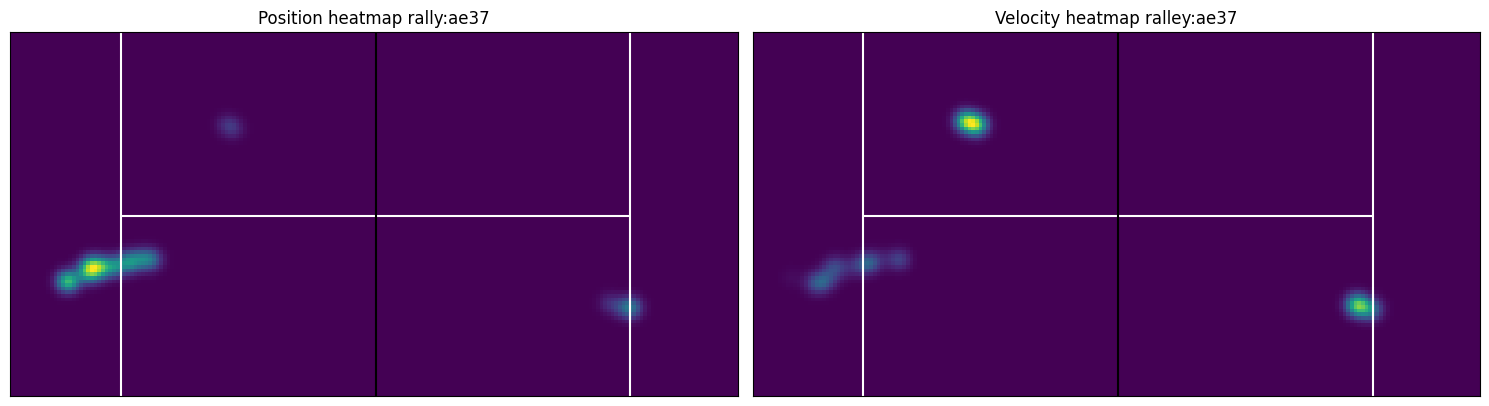

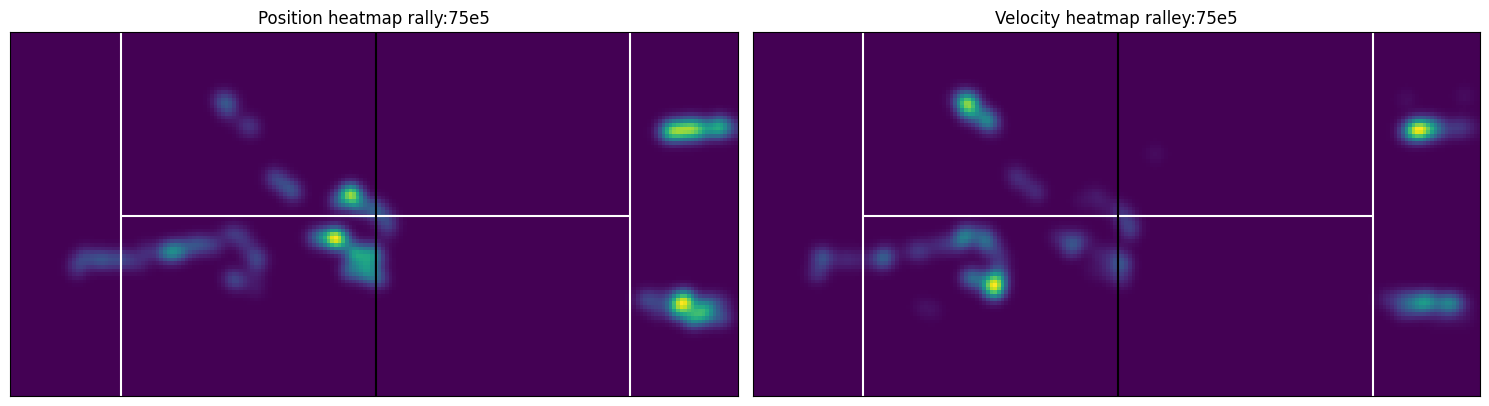

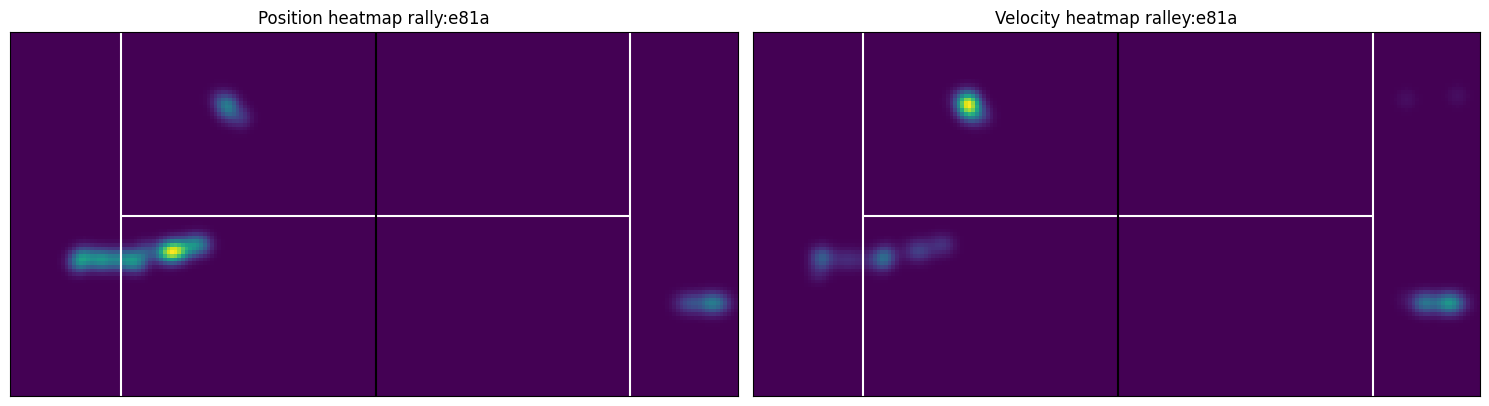

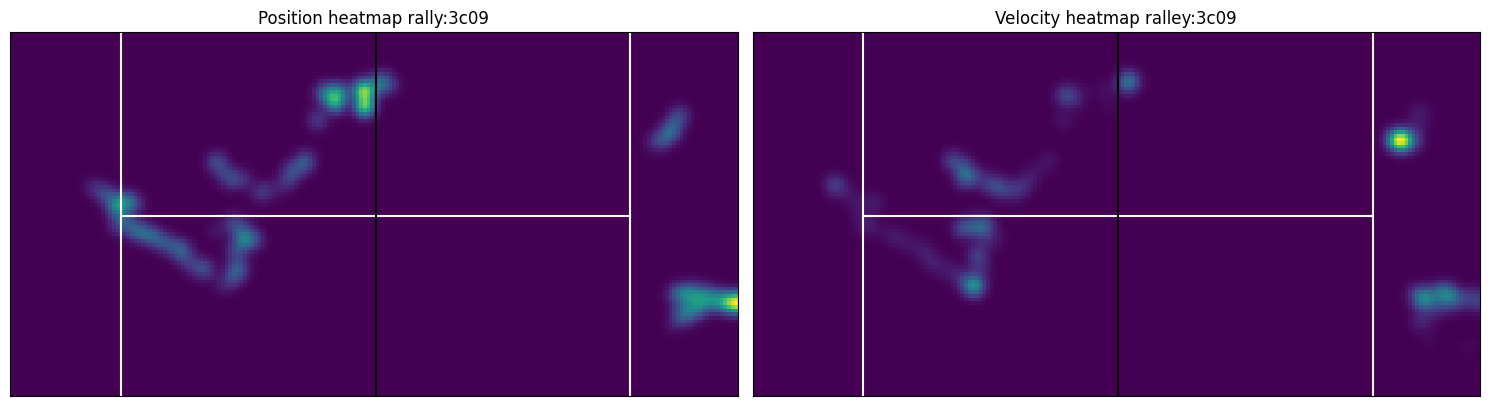

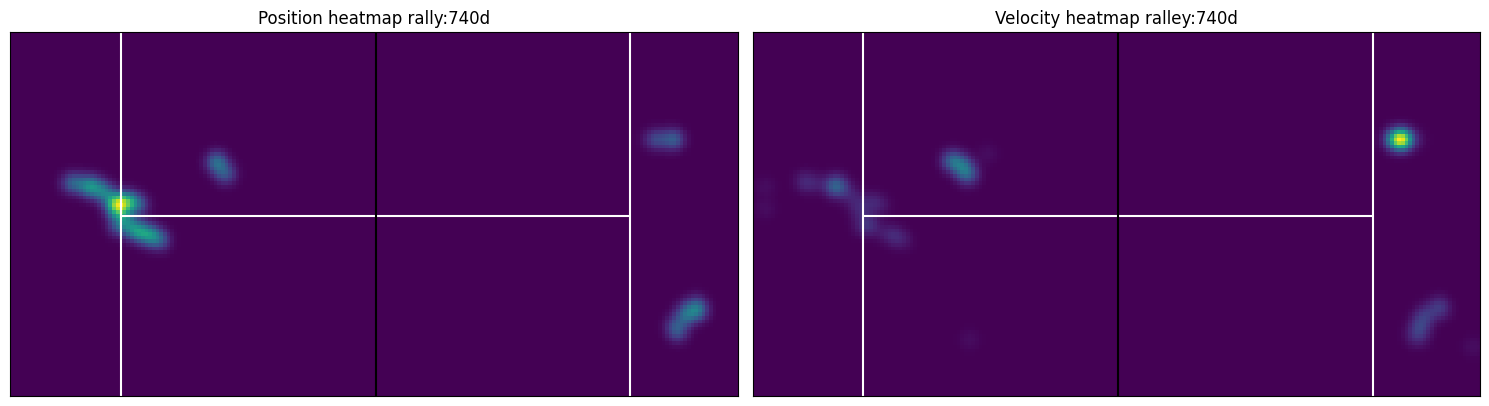

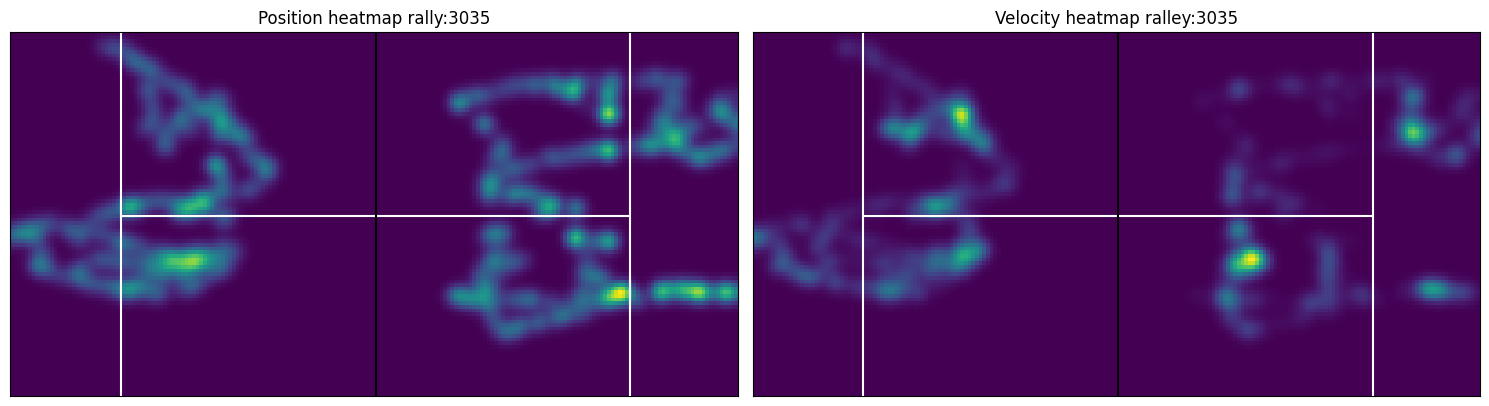

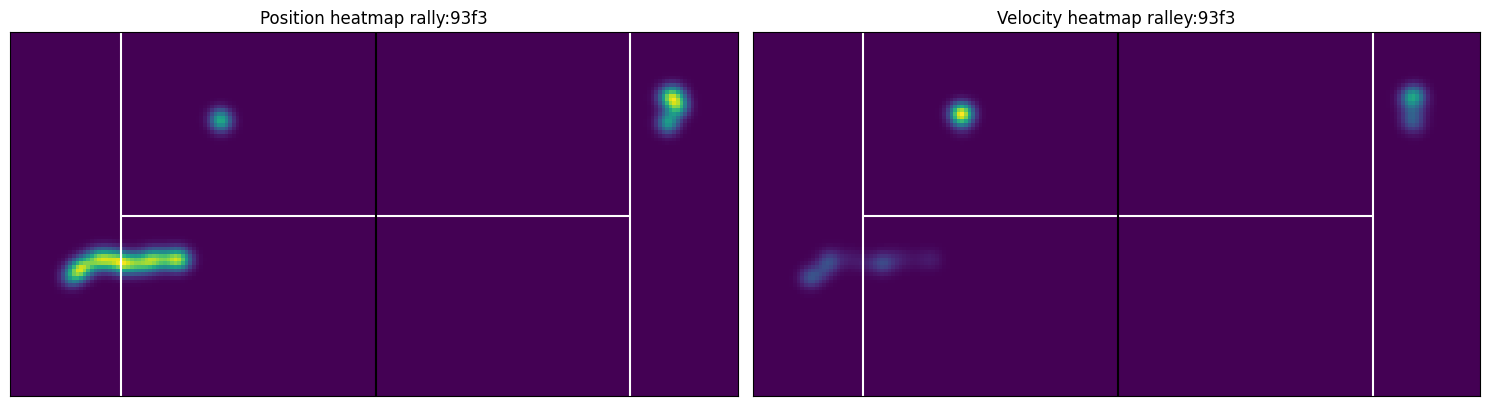

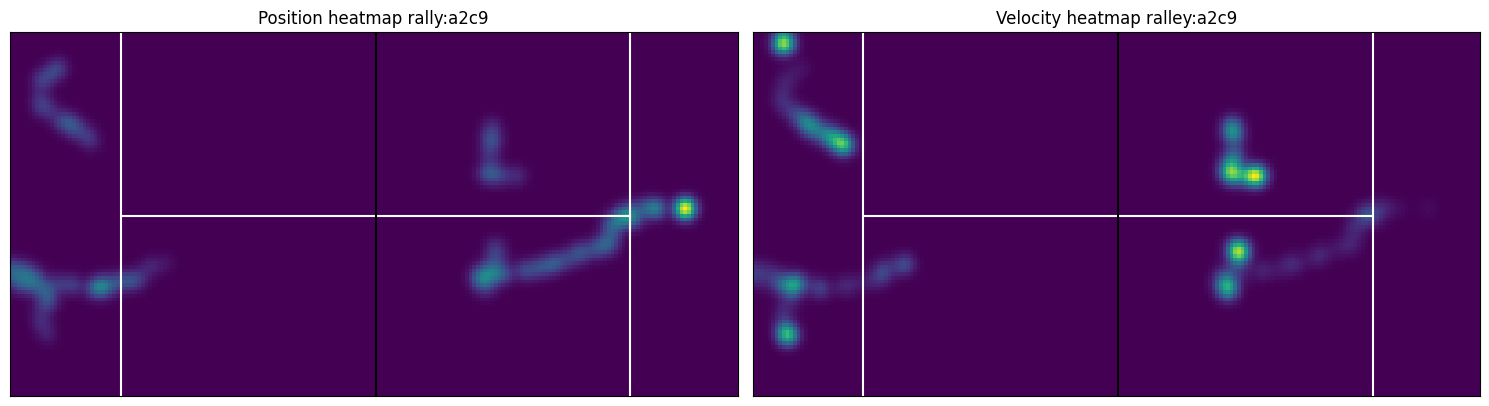

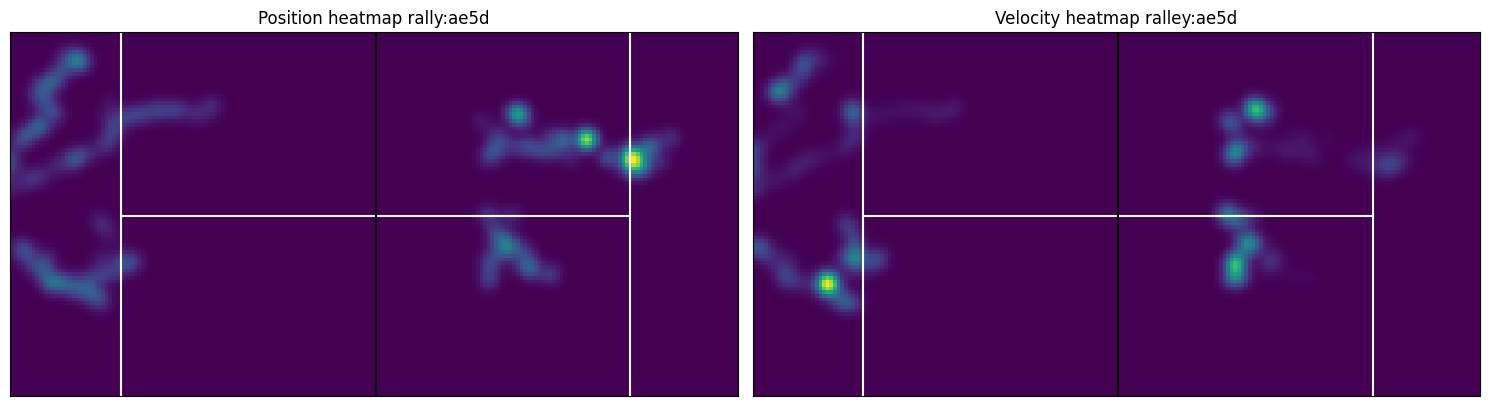

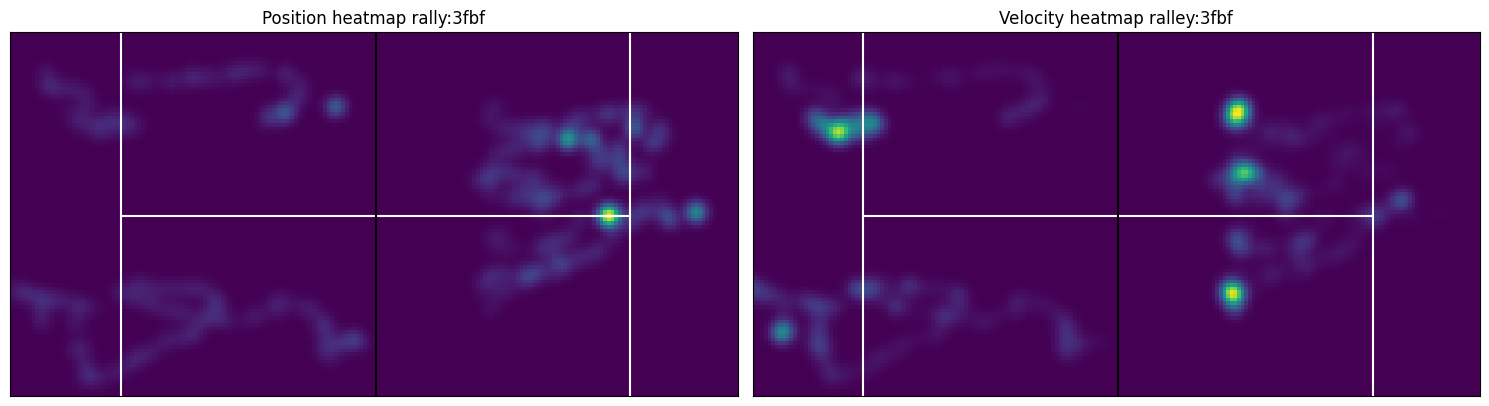

In [87]:
import matplotlib.pyplot as plt
from courtvision.vis import plot_n_images_in_a_grid, plot_3d_lines

clip_keys = list(heatmaps.keys())
for clip_key in clip_keys:
    vel_heatmap, pos_heatmap = velocity_heatmaps.get(clip_key), heatmaps.get(clip_key)
    if vel_heatmap is None or pos_heatmap is None:
        continue
    fig, ax = plot_n_images_in_a_grid(
        [
            gaussian_filter(vel_heatmap / vel_heatmap.max(), sigma=2.0),
            gaussian_filter(pos_heatmap / pos_heatmap.max(), sigma=2.0),
        ],
        n_cols=2,
    )
    ax[0][0].set_title(f"Position heatmap rally:{clip_key[-4:]}")
    ax[0][1].set_title(f"Velocity heatmap ralley:{clip_key[-4:]}")
    ax[0][0].set_xticks([])
    ax[0][0].set_yticks([])
    ax[0][1].set_xticks([])
    ax[0][1].set_yticks([])

    # Left service line
    ax[0][0].axvline(x=30, color="w")
    ax[0][1].axvline(x=30, color="w")

    # Right service line
    ax[0][0].axvline(x=170, color="w")
    ax[0][1].axvline(x=170, color="w")

    # center line
    ax[0][0].hlines(y=50, xmin=30, xmax=170, color="w")
    ax[0][1].hlines(y=50, xmin=30, xmax=170, color="w")

    # Net line
    ax[0][0].axvline(x=100, color="black")
    ax[0][1].axvline(x=100, color="black")

    fig.tight_layout()
    plt.show()

In [60]:
import pandas as pd

dd = pd.DataFrame(velocity_heatmaps["d"].flatten())
dd.describe()

,0
count,20000.0
mean,15897862.0
std,43421164.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,348668896.0


In [63]:
velocity_heatmaps["d"].m()

tensor(0.)